In [1]:
# Import packages
import numpy as np
import pandas as pd
import sys
from datetime import datetime
sys.path.append('../..')
import pickle

import h5py
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, MaxPooling2D, Conv2D
from keras.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import missingno as msno

from Classifier.data_processing import processor

Using TensorFlow backend.


In [2]:
# Load previously downloaded and processed market data from pickle. Option to redownload data if needed.

load_pickle = True
start_time = datetime(2016,1,1)
end_time = datetime(2018,2,25)
interval = 1440 # 1440 minutes = 1 day

if load_pickle:
    with open('pickles/core_data.pickle', 'rb') as f:
                data = pickle.load(f)
else:
    data = processor.historical_download(start_time, end_time, interval)
    with open('pickles/core_data.pickle', 'wb') as f:
                pickle.dump(data, f)

## Data preparation and scrubbing

In [19]:
"""
Scrub non-viable data
A lot of this data is legacy stuff that was being tested for importance. In future none of this data will be 
included in the dataset so scrubbing won't be needed
"""

def scrub(data):
    # Drop incomplete data
    try:
        data.drop('Ltc_search_US', axis=1, inplace=True)
        data.drop('Ltc_search_GB', axis=1, inplace=True)
        data.drop('Ltc_search_FR', axis=1, inplace=True)
        data.drop('Ltc_search_DE', axis=1, inplace=True)
        data.drop('Ltc_search_RU', axis=1, inplace=True)
        data.drop('Ltc_search_KR', axis=1, inplace=True)
        data.drop('Eth_search_US', axis=1, inplace=True)
        data.drop('Eth_search_GB', axis=1, inplace=True)
        data.drop('Eth_search_FR', axis=1, inplace=True)
        data.drop('Eth_search_DE', axis=1, inplace=True)
        data.drop('Eth_search_RU', axis=1, inplace=True)
        data.drop('Eth_search_KR', axis=1, inplace=True)
        data.drop('Btc_search_US', axis=1, inplace=True)
        data.drop('Btc_search_GB', axis=1, inplace=True)
        data.drop('Btc_search_FR', axis=1, inplace=True)
        data.drop('Btc_search_DE', axis=1, inplace=True)
        data.drop('Btc_search_RU', axis=1, inplace=True)
        data.drop('Btc_search_KR', axis=1, inplace=True)
        data.drop('Etheur_gdax_low', axis=1, inplace=True)
        data.drop('Etheur_gdax_high', axis=1, inplace=True)
        data.drop('Etheur_gdax_open', axis=1, inplace=True)
        data.drop('Etheur_gdax_close', axis=1, inplace=True)
        data.drop('Etheur_gdax_vol', axis=1, inplace=True)
        data.drop('Ltcusd_gdax_low', axis=1, inplace=True)
        data.drop('Ltcusd_gdax_high', axis=1, inplace=True)
        data.drop('Ltcusd_gdax_open', axis=1, inplace=True)
        data.drop('Ltcusd_gdax_close', axis=1, inplace=True)
        data.drop('Ltcusd_gdax_vol', axis=1, inplace=True)
        data.drop('Ltceur_gdax_low', axis=1, inplace=True)
        data.drop('Ltceur_gdax_high', axis=1, inplace=True)
        data.drop('Ltceur_gdax_open', axis=1, inplace=True)
        data.drop('Ltceur_gdax_close', axis=1, inplace=True)
        data.drop('Ltceur_gdax_vol', axis=1, inplace=True)
    except:
        pass
    
    
    # Testing only: drop google search trend data
    try:
        data.drop('Eth_search_worldwide', axis=1, inplace=True)
        data.drop('Ltc_search_worldwide', axis=1, inplace=True)
        data.drop('Btc_search_worldwide', axis=1, inplace=True)
    except:
        pass
    
    # Testing only: drop LTC blockchain network data
    try:
        data.drop('Ltc_hashrate', axis=1, inplace=True)
        data.drop('Ltc_addresses', axis=1, inplace=True)
        data.drop('Ltc_supply', axis=1, inplace=True)
        data.drop('Ltc_daily_trx', axis=1, inplace=True)
        data.drop('Ltc_fee_per_trx', axis=1, inplace=True)
    except:
        pass
    
    # Testing only: drop BTC blockchain network data
    try:
        data.drop('Btc_hashrate', axis=1, inplace=True)
        data.drop('Btc_addresses', axis=1, inplace=True)
        data.drop('Btc_supply', axis=1, inplace=True)
        data.drop('Btc_daily_trx', axis=1, inplace=True)
        data.drop('Btc_fee_per_trx', axis=1, inplace=True)
    except:
        pass
    
    # Testing only: drop ETH blockchain network data
    try:
        data.drop('Eth_hashrate', axis=1, inplace=True)
        data.drop('Eth_addresses', axis=1, inplace=True)
        data.drop('Eth_supply', axis=1, inplace=True)
        data.drop('Eth_daily_trx', axis=1, inplace=True)
        data.drop('Eth_fee_per_trx', axis=1, inplace=True)
    except:
        pass

    # Testing only: drop LTC-USD kraken market data
    try:
        data.drop('Ltcusd_kraken_open', axis=1, inplace=True)
        data.drop('Ltcusd_kraken_high', axis=1, inplace=True)
        data.drop('Ltcusd_kraken_low', axis=1, inplace=True)
        data.drop('Ltcusd_kraken_close', axis=1, inplace=True)
        data.drop('Ltcusd_kraken_vol', axis=1, inplace=True)
    except:
        pass
    
    # Testing only: drop BTC-USD gdax market data
    #try:
        #data.drop('Btcusd_gdax_open', axis=1, inplace=True)
        #data.drop('Btcusd_gdax_high', axis=1, inplace=True)
        #data.drop('Btcusd_gdax_low', axis=1, inplace=True)
        #data.drop('Btcusd_gdax_close', axis=1, inplace=True)
        #data.drop('Btcusd_gdax_vol', axis=1, inplace=True)
    #except:
    #   pass

    # Testing only: drop LTC-EUR kraken market data
    try:
        data.drop('Ltceur_kraken_open', axis=1, inplace=True)
        data.drop('Ltceur_kraken_high', axis=1, inplace=True)
        data.drop('Ltceur_kraken_low', axis=1, inplace=True)
        data.drop('Ltceur_kraken_close', axis=1, inplace=True)
        data.drop('Ltceur_kraken_vol', axis=1, inplace=True)
    except:
        pass
    
    # Testing only: drop BTC-EUR gdax market data
    #try:
        #data.drop('Btceur_gdax_open', axis=1, inplace=True)
        #data.drop('Btceur_gdax_high', axis=1, inplace=True)
        #data.drop('Btceur_gdax_low', axis=1, inplace=True)
        #data.drop('Btceur_gdax_close', axis=1, inplace=True)
        #data.drop('Btceur_gdax_vol', axis=1, inplace=True)
    #except:
    #   pass

    # Testing only: drop ETH-USD kraken market data
    #try:
       #data.drop('Ethusd_kraken_open', axis=1, inplace=True)
        #data.drop('Ethusd_kraken_high', axis=1, inplace=True)
        #data.drop('Ethusd_kraken_low', axis=1, inplace=True)
        #data.drop('Ethusd_kraken_close', axis=1, inplace=True)
        #data.drop('Ethusd_kraken_vol', axis=1, inplace=True)
    #except:
    #   pass


    # Testing only: drop ETH-USD gdax market data
    #try:
        #data.drop('Ethusd_gdax_open', axis=1, inplace=True)
        #data.drop('Ethusd_gdax_high', axis=1, inplace=True)
        #data.drop('Ethusd_gdax_low', axis=1, inplace=True)
        #data.drop('Ethusd_gdax_close', axis=1, inplace=True)
        #data.drop('Ethusd_gdax_vol', axis=1, inplace=True)
    #except:
        #pass
    
    # Testing only: drop ETH-EUR kraken market data
    #try:
        #data.drop('Etheur_kraken_open', axis=1, inplace=True)
        #data.drop('Etheur_kraken_high', axis=1, inplace=True)
        #data.drop('Etheur_kraken_low', axis=1, inplace=True)
        #data.drop('Etheur_kraken_close', axis=1, inplace=True)
        #data.drop('Etheur_kraken_vol', axis=1, inplace=True)
    #except:
        #pass

    #data.drop('Ethusd_kraken_close', axis=1, inplace=True)
    #data.drop('Btceur_kraken_open', axis=1, inplace=True)
    data = data.astype('float64')
    data = data.interpolate()
    return data

data = scrub(data)

In [20]:
"""
Data visualisation to understand where missing data and null values are. Commented out as all validation on this
dataset has been done many times already
"""

#%matplotlib inline
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(data.head(1))
#msno.matrix(data)
#data.isnull().sum()

'\nData visualisation to understand where missing data and null values are. Commented out as all validation on this\ndataset has been done many times already\n'

In [5]:
"""
Split data into training set and targets. Target variable selects the price we're looking to predict. 
Forecast_range sets how many time periods / intervals out we're looking at. Currently set to 1 period of 1440 minutes i.e. 1 day
"""
target = "Btcusd_kraken_close"
forecast_range = 1
x, y, actuals = processor.generate_x_y(data, target=target, forecast_range=1)

In [6]:
"""
Normalise data
"""
x_mean = x.mean(axis=0)
x_std = x.std(axis=0)
x = (x - x_mean) / x_std
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

In [7]:
"""
Split data into training vs validation sets
"""
train_x, valid_x = x[:-30], x[-30:]
train_y, valid_y = y[:-30], y[-30:]
actuals = actuals[-30:] # These are raw prices to use when calculating actual returns from growth rates 

## Prediction using LSTM

In [8]:
# Reshape data from (num_samples, features) to (num_samples, sequence_length, features)
sequence_length = 4

def seq_data(data_x, data_y, seq_length):
    seq_data_x = []
    seq_data_y = []
    for ii in range(len(data_x) - seq_length + 1):
        seq_data_x.append(data_x[ii : ii + seq_length])
        seq_data_y.append(data_y[ii + seq_length-1])
    return np.array(seq_data_x), np.array(seq_data_y)

# Add the last x time periods from before the validation set starts so that the first datapoint for the validation data
# also has the relevant price history for predictions
valid_x_2 = np.concatenate((train_x[-sequence_length + 1:], valid_x)) # Give full sequence length to first validation datapoint
valid_y_2 = np.concatenate((train_y[-sequence_length + 1:], valid_y)) # Give full sequence length to first validation datapoint

# Convert to sequential data feed for LSTM
train_x_seq, train_y_seq = seq_data(train_x, train_y, sequence_length)
valid_x_seq, valid_y_seq = seq_data(valid_x_2, valid_y_2, sequence_length)

In [9]:
class LSTM_net:
    """
    RNN using LSTM
    """
    def __init__(self, input_size, learning_rate):
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.build_model()

    def build_model(self):
        self.model = Sequential()
        self.model.add(LSTM(256, return_sequences=True,
                       input_shape=self.input_size))  
        #self.model.add(Dropout(0.2))
        self.model.add(LSTM(256))  
        #self.model.add(Dropout(0.2))
        self.model.add(Dense(1, activation='linear'))

        # Define optimiser and compile
        optimizer = optimizers.Adam(self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

In [10]:
# Initialise weight saving callback
LSTM_checkpointer = ModelCheckpoint(filepath='./saved_models/LSTM_weights.hdf5',
                       verbose=1, save_best_only=True)

In [11]:
# Initialise training hyper parameters
learning_rate = 0.00001
input_size = (train_x_seq.shape[1], train_x_seq.shape[2])
epochs = 1500
batch_size = 64

# Initialise neural network
LSTM_network = LSTM_net(input_size, learning_rate)

In [12]:
# Start training
LSTM_network.model.fit(train_x_seq, train_y_seq,
          batch_size=batch_size, epochs=epochs,
          callbacks=[LSTM_checkpointer],
          validation_data=(valid_x_seq, valid_y_seq))

Train on 637 samples, validate on 30 samples
Epoch 1/1500
637/637 [==============================] - 2s 4ms/step - loss: 0.9139 - acc: 0.0000e+00 - val_loss: 2.6636 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 2.66356, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 2/1500
637/637 [==============================] - 1s 901us/step - loss: 0.9103 - acc: 0.0000e+00 - val_loss: 2.6527 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 2.66356 to 2.65269, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 3/1500
637/637 [==============================] - 1s 938us/step - loss: 0.9065 - acc: 0.0000e+00 - val_loss: 2.6428 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 2.65269 to 2.64284, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 4/1500
637/637 [==============================] - 1s 895us/step - loss: 0.9031 - acc: 0.0000e+00 - val_loss: 2.6328 - val_acc: 0.0000e+00

Epoch 00004: val_loss improved from 2.64284 to 2.63284, saving mod


Epoch 00033: val_loss improved from 2.44139 to 2.43560, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 34/1500
637/637 [==============================] - 1s 873us/step - loss: 0.8192 - acc: 0.0000e+00 - val_loss: 2.4297 - val_acc: 0.0000e+00

Epoch 00034: val_loss improved from 2.43560 to 2.42967, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 35/1500
637/637 [==============================] - 1s 804us/step - loss: 0.8166 - acc: 0.0000e+00 - val_loss: 2.4240 - val_acc: 0.0000e+00

Epoch 00035: val_loss improved from 2.42967 to 2.42400, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 36/1500
637/637 [==============================] - 0s 782us/step - loss: 0.8137 - acc: 0.0000e+00 - val_loss: 2.4181 - val_acc: 0.0000e+00

Epoch 00036: val_loss improved from 2.42400 to 2.41814, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 37/1500
637/637 [==============================] - 1s 798us/step - loss: 0.8110 - acc: 0.0000e+00 - val_loss: 2.4128 - val_acc: 0.0000e

637/637 [==============================] - 1s 895us/step - loss: 0.7270 - acc: 0.0000e+00 - val_loss: 2.2414 - val_acc: 0.0000e+00

Epoch 00066: val_loss improved from 2.24784 to 2.24142, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 67/1500
637/637 [==============================] - 1s 871us/step - loss: 0.7237 - acc: 0.0000e+00 - val_loss: 2.2350 - val_acc: 0.0000e+00

Epoch 00067: val_loss improved from 2.24142 to 2.23500, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 68/1500
637/637 [==============================] - 1s 876us/step - loss: 0.7207 - acc: 0.0000e+00 - val_loss: 2.2281 - val_acc: 0.0000e+00

Epoch 00068: val_loss improved from 2.23500 to 2.22813, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 69/1500
637/637 [==============================] - 1s 856us/step - loss: 0.7174 - acc: 0.0000e+00 - val_loss: 2.2217 - val_acc: 0.0000e+00

Epoch 00069: val_loss improved from 2.22813 to 2.22169, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 70/1

Epoch 99/1500
637/637 [==============================] - 1s 873us/step - loss: 0.6180 - acc: 0.0000e+00 - val_loss: 2.0050 - val_acc: 0.0000e+00

Epoch 00099: val_loss improved from 2.01397 to 2.00499, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 100/1500
637/637 [==============================] - 1s 901us/step - loss: 0.6147 - acc: 0.0000e+00 - val_loss: 1.9960 - val_acc: 0.0000e+00

Epoch 00100: val_loss improved from 2.00499 to 1.99605, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 101/1500
637/637 [==============================] - 1s 930us/step - loss: 0.6110 - acc: 0.0000e+00 - val_loss: 1.9879 - val_acc: 0.0000e+00

Epoch 00101: val_loss improved from 1.99605 to 1.98792, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 102/1500
637/637 [==============================] - 1s 932us/step - loss: 0.6074 - acc: 0.0000e+00 - val_loss: 1.9801 - val_acc: 0.0000e+00

Epoch 00102: val_loss improved from 1.98792 to 1.98015, saving model to ./saved_models/LSTM_weight


Epoch 00131: val_loss improved from 1.72290 to 1.71260, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 132/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.4986 - acc: 0.0000e+00 - val_loss: 1.7037 - val_acc: 0.0000e+00

Epoch 00132: val_loss improved from 1.71260 to 1.70366, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 133/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.4945 - acc: 0.0000e+00 - val_loss: 1.6944 - val_acc: 0.0000e+00

Epoch 00133: val_loss improved from 1.70366 to 1.69444, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 134/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.4913 - acc: 0.0000e+00 - val_loss: 1.6839 - val_acc: 0.0000e+00

Epoch 00134: val_loss improved from 1.69444 to 1.68389, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 135/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.4874 - acc: 0.0000e+00 - val_loss: 1.6733 - val_acc: 0.0000e+00


637/637 [==============================] - 1s 1ms/step - loss: 0.3843 - acc: 0.0000e+00 - val_loss: 1.3945 - val_acc: 0.0000e+00

Epoch 00164: val_loss improved from 1.40323 to 1.39452, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 165/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.3810 - acc: 0.0000e+00 - val_loss: 1.3861 - val_acc: 0.0000e+00

Epoch 00165: val_loss improved from 1.39452 to 1.38606, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 166/1500
637/637 [==============================] - 1s 989us/step - loss: 0.3776 - acc: 0.0000e+00 - val_loss: 1.3772 - val_acc: 0.0000e+00

Epoch 00166: val_loss improved from 1.38606 to 1.37723, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 167/1500
637/637 [==============================] - 1s 982us/step - loss: 0.3746 - acc: 0.0000e+00 - val_loss: 1.3689 - val_acc: 0.0000e+00

Epoch 00167: val_loss improved from 1.37723 to 1.36890, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 168/1

Epoch 197/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.2922 - acc: 0.0000e+00 - val_loss: 1.1711 - val_acc: 0.0000e+00

Epoch 00197: val_loss improved from 1.17680 to 1.17107, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 198/1500
637/637 [==============================] - 1s 987us/step - loss: 0.2899 - acc: 0.0000e+00 - val_loss: 1.1672 - val_acc: 0.0000e+00

Epoch 00198: val_loss improved from 1.17107 to 1.16716, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 199/1500
637/637 [==============================] - 1s 997us/step - loss: 0.2879 - acc: 0.0000e+00 - val_loss: 1.1632 - val_acc: 0.0000e+00

Epoch 00199: val_loss improved from 1.16716 to 1.16318, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 200/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.2859 - acc: 0.0000e+00 - val_loss: 1.1598 - val_acc: 0.0000e+00

Epoch 00200: val_loss improved from 1.16318 to 1.15978, saving model to ./saved_models/LSTM_weights.h


Epoch 00229: val_loss improved from 1.09297 to 1.09131, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 230/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.2399 - acc: 0.0000e+00 - val_loss: 1.0913 - val_acc: 0.0000e+00

Epoch 00230: val_loss did not improve
Epoch 231/1500
637/637 [==============================] - 1s 995us/step - loss: 0.2388 - acc: 0.0000e+00 - val_loss: 1.0909 - val_acc: 0.0000e+00

Epoch 00231: val_loss improved from 1.09131 to 1.09085, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 232/1500
637/637 [==============================] - 1s 976us/step - loss: 0.2377 - acc: 0.0000e+00 - val_loss: 1.0895 - val_acc: 0.0000e+00

Epoch 00232: val_loss improved from 1.09085 to 1.08947, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 233/1500
637/637 [==============================] - 1s 951us/step - loss: 0.2367 - acc: 0.0000e+00 - val_loss: 1.0886 - val_acc: 0.0000e+00

Epoch 00233: val_loss improved from 1.08947 to 1.08855, savi

637/637 [==============================] - 1s 978us/step - loss: 0.2082 - acc: 0.0000e+00 - val_loss: 1.0926 - val_acc: 0.0000e+00

Epoch 00270: val_loss did not improve
Epoch 271/1500
637/637 [==============================] - 1s 953us/step - loss: 0.2077 - acc: 0.0000e+00 - val_loss: 1.0936 - val_acc: 0.0000e+00

Epoch 00271: val_loss did not improve
Epoch 272/1500
637/637 [==============================] - 1s 986us/step - loss: 0.2071 - acc: 0.0000e+00 - val_loss: 1.0954 - val_acc: 0.0000e+00

Epoch 00272: val_loss did not improve
Epoch 273/1500
637/637 [==============================] - 1s 996us/step - loss: 0.2066 - acc: 0.0000e+00 - val_loss: 1.0963 - val_acc: 0.0000e+00

Epoch 00273: val_loss did not improve
Epoch 274/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.2059 - acc: 0.0000e+00 - val_loss: 1.0954 - val_acc: 0.0000e+00

Epoch 00274: val_loss did not improve
Epoch 275/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.2054 - acc: 

637/637 [==============================] - 1s 987us/step - loss: 0.1856 - acc: 0.0000e+00 - val_loss: 1.1250 - val_acc: 0.0000e+00

Epoch 00314: val_loss did not improve
Epoch 315/1500
637/637 [==============================] - 1s 975us/step - loss: 0.1852 - acc: 0.0000e+00 - val_loss: 1.1239 - val_acc: 0.0000e+00

Epoch 00315: val_loss did not improve
Epoch 316/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.1848 - acc: 0.0000e+00 - val_loss: 1.1248 - val_acc: 0.0000e+00

Epoch 00316: val_loss did not improve
Epoch 317/1500
637/637 [==============================] - 1s 989us/step - loss: 0.1845 - acc: 0.0000e+00 - val_loss: 1.1281 - val_acc: 0.0000e+00

Epoch 00317: val_loss did not improve
Epoch 318/1500
637/637 [==============================] - 1s 994us/step - loss: 0.1839 - acc: 0.0000e+00 - val_loss: 1.1277 - val_acc: 0.0000e+00

Epoch 00318: val_loss did not improve
Epoch 319/1500
637/637 [==============================] - 1s 978us/step - loss: 0.1834 - acc

637/637 [==============================] - 1s 1ms/step - loss: 0.1680 - acc: 0.0000e+00 - val_loss: 1.1568 - val_acc: 0.0000e+00

Epoch 00358: val_loss did not improve
Epoch 359/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.1677 - acc: 0.0000e+00 - val_loss: 1.1566 - val_acc: 0.0000e+00

Epoch 00359: val_loss did not improve
Epoch 360/1500
637/637 [==============================] - 1s 982us/step - loss: 0.1674 - acc: 0.0000e+00 - val_loss: 1.1574 - val_acc: 0.0000e+00

Epoch 00360: val_loss did not improve
Epoch 361/1500
637/637 [==============================] - 1s 996us/step - loss: 0.1670 - acc: 0.0000e+00 - val_loss: 1.1579 - val_acc: 0.0000e+00

Epoch 00361: val_loss did not improve
Epoch 362/1500
637/637 [==============================] - 1s 974us/step - loss: 0.1667 - acc: 0.0000e+00 - val_loss: 1.1592 - val_acc: 0.0000e+00

Epoch 00362: val_loss did not improve
Epoch 363/1500
637/637 [==============================] - 1s 992us/step - loss: 0.1663 - acc: 


Epoch 00402: val_loss did not improve
Epoch 403/1500
637/637 [==============================] - 1s 992us/step - loss: 0.1535 - acc: 0.0000e+00 - val_loss: 1.1813 - val_acc: 0.0000e+00

Epoch 00403: val_loss did not improve
Epoch 404/1500
637/637 [==============================] - 1s 965us/step - loss: 0.1531 - acc: 0.0000e+00 - val_loss: 1.1831 - val_acc: 0.0000e+00

Epoch 00404: val_loss did not improve
Epoch 405/1500
637/637 [==============================] - 1s 972us/step - loss: 0.1528 - acc: 0.0000e+00 - val_loss: 1.1846 - val_acc: 0.0000e+00

Epoch 00405: val_loss did not improve
Epoch 406/1500
637/637 [==============================] - 1s 987us/step - loss: 0.1525 - acc: 0.0000e+00 - val_loss: 1.1859 - val_acc: 0.0000e+00

Epoch 00406: val_loss did not improve
Epoch 407/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.1522 - acc: 0.0000e+00 - val_loss: 1.1864 - val_acc: 0.0000e+00

Epoch 00407: val_loss did not improve
Epoch 408/1500
637/637 [==============

637/637 [==============================] - 1s 1ms/step - loss: 0.1413 - acc: 0.0000e+00 - val_loss: 1.1974 - val_acc: 0.0000e+00

Epoch 00447: val_loss did not improve
Epoch 448/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.1410 - acc: 0.0000e+00 - val_loss: 1.1980 - val_acc: 0.0000e+00

Epoch 00448: val_loss did not improve
Epoch 449/1500
637/637 [==============================] - 1s 995us/step - loss: 0.1409 - acc: 0.0000e+00 - val_loss: 1.1971 - val_acc: 0.0000e+00

Epoch 00449: val_loss did not improve
Epoch 450/1500
637/637 [==============================] - 1s 966us/step - loss: 0.1405 - acc: 0.0000e+00 - val_loss: 1.1983 - val_acc: 0.0000e+00

Epoch 00450: val_loss did not improve
Epoch 451/1500
637/637 [==============================] - 1s 967us/step - loss: 0.1403 - acc: 0.0000e+00 - val_loss: 1.1976 - val_acc: 0.0000e+00

Epoch 00451: val_loss did not improve
Epoch 452/1500
637/637 [==============================] - 1s 984us/step - loss: 0.1400 - acc: 


Epoch 00491: val_loss did not improve
Epoch 492/1500
637/637 [==============================] - 1s 986us/step - loss: 0.1305 - acc: 0.0000e+00 - val_loss: 1.1986 - val_acc: 0.0000e+00

Epoch 00492: val_loss did not improve
Epoch 493/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.1303 - acc: 0.0000e+00 - val_loss: 1.1975 - val_acc: 0.0000e+00

Epoch 00493: val_loss did not improve
Epoch 494/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.1300 - acc: 0.0000e+00 - val_loss: 1.1979 - val_acc: 0.0000e+00

Epoch 00494: val_loss did not improve
Epoch 495/1500
637/637 [==============================] - 1s 986us/step - loss: 0.1298 - acc: 0.0000e+00 - val_loss: 1.1976 - val_acc: 0.0000e+00

Epoch 00495: val_loss did not improve
Epoch 496/1500
637/637 [==============================] - 1s 979us/step - loss: 0.1297 - acc: 0.0000e+00 - val_loss: 1.1978 - val_acc: 0.0000e+00

Epoch 00496: val_loss did not improve
Epoch 497/1500
637/637 [================

637/637 [==============================] - 1s 1ms/step - loss: 0.1212 - acc: 0.0000e+00 - val_loss: 1.1874 - val_acc: 0.0000e+00

Epoch 00536: val_loss did not improve
Epoch 537/1500
637/637 [==============================] - 1s 981us/step - loss: 0.1210 - acc: 0.0000e+00 - val_loss: 1.1850 - val_acc: 0.0000e+00

Epoch 00537: val_loss did not improve
Epoch 538/1500
637/637 [==============================] - 1s 973us/step - loss: 0.1208 - acc: 0.0000e+00 - val_loss: 1.1837 - val_acc: 0.0000e+00

Epoch 00538: val_loss did not improve
Epoch 539/1500
637/637 [==============================] - 1s 998us/step - loss: 0.1206 - acc: 0.0000e+00 - val_loss: 1.1839 - val_acc: 0.0000e+00

Epoch 00539: val_loss did not improve
Epoch 540/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.1203 - acc: 0.0000e+00 - val_loss: 1.1842 - val_acc: 0.0000e+00

Epoch 00540: val_loss did not improve
Epoch 541/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.1202 - acc: 0.


Epoch 00580: val_loss did not improve
Epoch 581/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.1127 - acc: 0.0000e+00 - val_loss: 1.1685 - val_acc: 0.0000e+00

Epoch 00581: val_loss did not improve
Epoch 582/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.1124 - acc: 0.0000e+00 - val_loss: 1.1656 - val_acc: 0.0000e+00

Epoch 00582: val_loss did not improve
Epoch 583/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.1123 - acc: 0.0000e+00 - val_loss: 1.1628 - val_acc: 0.0000e+00

Epoch 00583: val_loss did not improve
Epoch 584/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.1120 - acc: 0.0000e+00 - val_loss: 1.1592 - val_acc: 0.0000e+00

Epoch 00584: val_loss did not improve
Epoch 585/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.1119 - acc: 0.0000e+00 - val_loss: 1.1609 - val_acc: 0.0000e+00

Epoch 00585: val_loss did not improve
Epoch 586/1500
637/637 [======================

637/637 [==============================] - 1s 1ms/step - loss: 0.1049 - acc: 0.0000e+00 - val_loss: 1.1341 - val_acc: 0.0000e+00

Epoch 00625: val_loss did not improve
Epoch 626/1500
637/637 [==============================] - 1s 966us/step - loss: 0.1048 - acc: 0.0000e+00 - val_loss: 1.1359 - val_acc: 0.0000e+00

Epoch 00626: val_loss did not improve
Epoch 627/1500
637/637 [==============================] - 1s 963us/step - loss: 0.1047 - acc: 0.0000e+00 - val_loss: 1.1310 - val_acc: 0.0000e+00

Epoch 00627: val_loss did not improve
Epoch 628/1500
637/637 [==============================] - 1s 946us/step - loss: 0.1044 - acc: 0.0000e+00 - val_loss: 1.1313 - val_acc: 0.0000e+00

Epoch 00628: val_loss did not improve
Epoch 629/1500
637/637 [==============================] - 1s 991us/step - loss: 0.1043 - acc: 0.0000e+00 - val_loss: 1.1299 - val_acc: 0.0000e+00

Epoch 00629: val_loss did not improve
Epoch 630/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.1041 - acc: 

637/637 [==============================] - 1s 964us/step - loss: 0.0980 - acc: 0.0000e+00 - val_loss: 1.1009 - val_acc: 0.0000e+00

Epoch 00669: val_loss did not improve
Epoch 670/1500
637/637 [==============================] - 1s 953us/step - loss: 0.0977 - acc: 0.0000e+00 - val_loss: 1.0979 - val_acc: 0.0000e+00

Epoch 00670: val_loss did not improve
Epoch 671/1500
637/637 [==============================] - 1s 998us/step - loss: 0.0976 - acc: 0.0000e+00 - val_loss: 1.0958 - val_acc: 0.0000e+00

Epoch 00671: val_loss did not improve
Epoch 672/1500
637/637 [==============================] - 1s 987us/step - loss: 0.0975 - acc: 0.0000e+00 - val_loss: 1.0956 - val_acc: 0.0000e+00

Epoch 00672: val_loss did not improve
Epoch 673/1500
637/637 [==============================] - 1s 982us/step - loss: 0.0973 - acc: 0.0000e+00 - val_loss: 1.0944 - val_acc: 0.0000e+00

Epoch 00673: val_loss did not improve
Epoch 674/1500
637/637 [==============================] - 1s 988us/step - loss: 0.0971 - a


Epoch 00709: val_loss improved from 1.06473 to 1.06384, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 710/1500
637/637 [==============================] - 1s 984us/step - loss: 0.0919 - acc: 0.0000e+00 - val_loss: 1.0632 - val_acc: 0.0000e+00

Epoch 00710: val_loss improved from 1.06384 to 1.06323, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 711/1500
637/637 [==============================] - 1s 952us/step - loss: 0.0917 - acc: 0.0000e+00 - val_loss: 1.0619 - val_acc: 0.0000e+00

Epoch 00711: val_loss improved from 1.06323 to 1.06194, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 712/1500
637/637 [==============================] - 1s 974us/step - loss: 0.0915 - acc: 0.0000e+00 - val_loss: 1.0593 - val_acc: 0.0000e+00

Epoch 00712: val_loss improved from 1.06194 to 1.05934, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 713/1500
637/637 [==============================] - 1s 967us/step - loss: 0.0914 - acc: 0.0000e+00 - val_loss: 1.0577 - val_acc: 0.0


Epoch 00747: val_loss improved from 1.03261 to 1.02970, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 748/1500
637/637 [==============================] - 1s 990us/step - loss: 0.0867 - acc: 0.0000e+00 - val_loss: 1.0320 - val_acc: 0.0000e+00

Epoch 00748: val_loss did not improve
Epoch 749/1500
637/637 [==============================] - 1s 984us/step - loss: 0.0865 - acc: 0.0000e+00 - val_loss: 1.0306 - val_acc: 0.0000e+00

Epoch 00749: val_loss did not improve
Epoch 750/1500
637/637 [==============================] - 1s 950us/step - loss: 0.0863 - acc: 0.0000e+00 - val_loss: 1.0259 - val_acc: 0.0000e+00

Epoch 00750: val_loss improved from 1.02970 to 1.02588, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 751/1500
637/637 [==============================] - 1s 968us/step - loss: 0.0862 - acc: 0.0000e+00 - val_loss: 1.0260 - val_acc: 0.0000e+00

Epoch 00751: val_loss did not improve
Epoch 752/1500
637/637 [==============================] - 1s 949us/step - loss: 0.0861 

637/637 [==============================] - 1s 993us/step - loss: 0.0818 - acc: 0.0000e+00 - val_loss: 0.9981 - val_acc: 0.0000e+00

Epoch 00785: val_loss improved from 0.99941 to 0.99810, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 786/1500
637/637 [==============================] - 1s 980us/step - loss: 0.0817 - acc: 0.0000e+00 - val_loss: 0.9969 - val_acc: 0.0000e+00

Epoch 00786: val_loss improved from 0.99810 to 0.99686, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 787/1500
637/637 [==============================] - 1s 961us/step - loss: 0.0816 - acc: 0.0000e+00 - val_loss: 1.0013 - val_acc: 0.0000e+00

Epoch 00787: val_loss did not improve
Epoch 788/1500
637/637 [==============================] - 1s 941us/step - loss: 0.0815 - acc: 0.0000e+00 - val_loss: 0.9962 - val_acc: 0.0000e+00

Epoch 00788: val_loss improved from 0.99686 to 0.99624, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 789/1500
637/637 [==============================] - 1s 965us/step - 

637/637 [==============================] - 1s 975us/step - loss: 0.0774 - acc: 0.0000e+00 - val_loss: 0.9705 - val_acc: 0.0000e+00

Epoch 00822: val_loss improved from 0.97090 to 0.97052, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 823/1500
637/637 [==============================] - 1s 970us/step - loss: 0.0773 - acc: 0.0000e+00 - val_loss: 0.9688 - val_acc: 0.0000e+00

Epoch 00823: val_loss improved from 0.97052 to 0.96884, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 824/1500
637/637 [==============================] - 1s 958us/step - loss: 0.0772 - acc: 0.0000e+00 - val_loss: 0.9693 - val_acc: 0.0000e+00

Epoch 00824: val_loss did not improve
Epoch 825/1500
637/637 [==============================] - 1s 957us/step - loss: 0.0770 - acc: 0.0000e+00 - val_loss: 0.9668 - val_acc: 0.0000e+00

Epoch 00825: val_loss improved from 0.96884 to 0.96680, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 826/1500
637/637 [==============================] - 1s 972us/step - 

637/637 [==============================] - 1s 1ms/step - loss: 0.0731 - acc: 0.0000e+00 - val_loss: 0.9410 - val_acc: 0.0000e+00

Epoch 00861: val_loss improved from 0.94233 to 0.94102, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 862/1500
637/637 [==============================] - 1s 970us/step - loss: 0.0730 - acc: 0.0000e+00 - val_loss: 0.9399 - val_acc: 0.0000e+00

Epoch 00862: val_loss improved from 0.94102 to 0.93990, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 863/1500
637/637 [==============================] - 1s 962us/step - loss: 0.0729 - acc: 0.0000e+00 - val_loss: 0.9397 - val_acc: 0.0000e+00

Epoch 00863: val_loss improved from 0.93990 to 0.93967, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 864/1500
637/637 [==============================] - 1s 956us/step - loss: 0.0728 - acc: 0.0000e+00 - val_loss: 0.9420 - val_acc: 0.0000e+00

Epoch 00864: val_loss did not improve
Epoch 865/1500
637/637 [==============================] - 1s 952us/step - lo

637/637 [==============================] - 1s 947us/step - loss: 0.0693 - acc: 0.0000e+00 - val_loss: 0.9159 - val_acc: 0.0000e+00

Epoch 00898: val_loss improved from 0.91676 to 0.91590, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 899/1500
637/637 [==============================] - 1s 937us/step - loss: 0.0692 - acc: 0.0000e+00 - val_loss: 0.9168 - val_acc: 0.0000e+00

Epoch 00899: val_loss did not improve
Epoch 900/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0692 - acc: 0.0000e+00 - val_loss: 0.9168 - val_acc: 0.0000e+00

Epoch 00900: val_loss did not improve
Epoch 901/1500
637/637 [==============================] - 1s 967us/step - loss: 0.0690 - acc: 0.0000e+00 - val_loss: 0.9135 - val_acc: 0.0000e+00

Epoch 00901: val_loss improved from 0.91590 to 0.91347, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 902/1500
637/637 [==============================] - 1s 984us/step - loss: 0.0689 - acc: 0.0000e+00 - val_loss: 0.9110 - val_acc: 0.0000e+

637/637 [==============================] - 1s 954us/step - loss: 0.0657 - acc: 0.0000e+00 - val_loss: 0.8941 - val_acc: 0.0000e+00

Epoch 00936: val_loss did not improve
Epoch 937/1500
637/637 [==============================] - 1s 962us/step - loss: 0.0656 - acc: 0.0000e+00 - val_loss: 0.8944 - val_acc: 0.0000e+00

Epoch 00937: val_loss did not improve
Epoch 938/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0655 - acc: 0.0000e+00 - val_loss: 0.8937 - val_acc: 0.0000e+00

Epoch 00938: val_loss did not improve
Epoch 939/1500
637/637 [==============================] - 1s 998us/step - loss: 0.0654 - acc: 0.0000e+00 - val_loss: 0.8909 - val_acc: 0.0000e+00

Epoch 00939: val_loss improved from 0.89213 to 0.89087, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 940/1500
637/637 [==============================] - 1s 959us/step - loss: 0.0653 - acc: 0.0000e+00 - val_loss: 0.8904 - val_acc: 0.0000e+00

Epoch 00940: val_loss improved from 0.89087 to 0.89037, saving 

Epoch 976/1500
637/637 [==============================] - 1s 947us/step - loss: 0.0622 - acc: 0.0000e+00 - val_loss: 0.8748 - val_acc: 0.0000e+00

Epoch 00976: val_loss did not improve
Epoch 977/1500
637/637 [==============================] - 1s 944us/step - loss: 0.0621 - acc: 0.0000e+00 - val_loss: 0.8725 - val_acc: 0.0000e+00

Epoch 00977: val_loss did not improve
Epoch 978/1500
637/637 [==============================] - 1s 971us/step - loss: 0.0620 - acc: 0.0000e+00 - val_loss: 0.8707 - val_acc: 0.0000e+00

Epoch 00978: val_loss improved from 0.87121 to 0.87074, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 979/1500
637/637 [==============================] - 1s 996us/step - loss: 0.0619 - acc: 0.0000e+00 - val_loss: 0.8724 - val_acc: 0.0000e+00

Epoch 00979: val_loss did not improve
Epoch 980/1500
637/637 [==============================] - 1s 951us/step - loss: 0.0618 - acc: 0.0000e+00 - val_loss: 0.8724 - val_acc: 0.0000e+00

Epoch 00980: val_loss did not improve
Epoch 98

637/637 [==============================] - 1s 1ms/step - loss: 0.0589 - acc: 0.0000e+00 - val_loss: 0.8530 - val_acc: 0.0000e+00

Epoch 01016: val_loss did not improve
Epoch 1017/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0588 - acc: 0.0000e+00 - val_loss: 0.8539 - val_acc: 0.0000e+00

Epoch 01017: val_loss did not improve
Epoch 1018/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0588 - acc: 0.0000e+00 - val_loss: 0.8546 - val_acc: 0.0000e+00

Epoch 01018: val_loss did not improve
Epoch 1019/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0587 - acc: 0.0000e+00 - val_loss: 0.8556 - val_acc: 0.0000e+00

Epoch 01019: val_loss did not improve
Epoch 1020/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0586 - acc: 0.0000e+00 - val_loss: 0.8518 - val_acc: 0.0000e+00

Epoch 01020: val_loss improved from 0.85240 to 0.85180, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 1021/1500
637/637 [====

Epoch 01056: val_loss did not improve
Epoch 1057/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0558 - acc: 0.0000e+00 - val_loss: 0.8375 - val_acc: 0.0000e+00

Epoch 01057: val_loss did not improve
Epoch 1058/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0557 - acc: 0.0000e+00 - val_loss: 0.8367 - val_acc: 0.0000e+00

Epoch 01058: val_loss did not improve
Epoch 1059/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0556 - acc: 0.0000e+00 - val_loss: 0.8348 - val_acc: 0.0000e+00

Epoch 01059: val_loss improved from 0.83646 to 0.83476, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 1060/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0555 - acc: 0.0000e+00 - val_loss: 0.8360 - val_acc: 0.0000e+00

Epoch 01060: val_loss did not improve
Epoch 1061/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0555 - acc: 0.0000e+00 - val_loss: 0.8366 - val_acc: 0.0000e+00

Epoch 01061: 

Epoch 1097/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0529 - acc: 0.0000e+00 - val_loss: 0.8218 - val_acc: 0.0000e+00

Epoch 01097: val_loss did not improve
Epoch 1098/1500
637/637 [==============================] - 1s 993us/step - loss: 0.0529 - acc: 0.0000e+00 - val_loss: 0.8237 - val_acc: 0.0000e+00

Epoch 01098: val_loss did not improve
Epoch 1099/1500
637/637 [==============================] - 1s 960us/step - loss: 0.0528 - acc: 0.0000e+00 - val_loss: 0.8172 - val_acc: 0.0000e+00

Epoch 01099: val_loss improved from 0.81905 to 0.81723, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 1100/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0528 - acc: 0.0000e+00 - val_loss: 0.8176 - val_acc: 0.0000e+00

Epoch 01100: val_loss did not improve
Epoch 1101/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0526 - acc: 0.0000e+00 - val_loss: 0.8188 - val_acc: 0.0000e+00

Epoch 01101: val_loss did not improve
Epoch 110

637/637 [==============================] - 1s 1ms/step - loss: 0.0502 - acc: 0.0000e+00 - val_loss: 0.8018 - val_acc: 0.0000e+00

Epoch 01138: val_loss improved from 0.80321 to 0.80182, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 1139/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0501 - acc: 0.0000e+00 - val_loss: 0.8051 - val_acc: 0.0000e+00

Epoch 01139: val_loss did not improve
Epoch 1140/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0500 - acc: 0.0000e+00 - val_loss: 0.8048 - val_acc: 0.0000e+00

Epoch 01140: val_loss did not improve
Epoch 1141/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0500 - acc: 0.0000e+00 - val_loss: 0.8037 - val_acc: 0.0000e+00

Epoch 01141: val_loss did not improve
Epoch 1142/1500
637/637 [==============================] - 1s 979us/step - loss: 0.0500 - acc: 0.0000e+00 - val_loss: 0.8037 - val_acc: 0.0000e+00

Epoch 01142: val_loss did not improve
Epoch 1143/1500
637/637 [==


Epoch 01179: val_loss did not improve
Epoch 1180/1500
637/637 [==============================] - 1s 949us/step - loss: 0.0476 - acc: 0.0000e+00 - val_loss: 0.7906 - val_acc: 0.0000e+00

Epoch 01180: val_loss did not improve
Epoch 1181/1500
637/637 [==============================] - 1s 931us/step - loss: 0.0475 - acc: 0.0000e+00 - val_loss: 0.7889 - val_acc: 0.0000e+00

Epoch 01181: val_loss did not improve
Epoch 1182/1500
637/637 [==============================] - 1s 955us/step - loss: 0.0475 - acc: 0.0000e+00 - val_loss: 0.7902 - val_acc: 0.0000e+00

Epoch 01182: val_loss did not improve
Epoch 1183/1500
637/637 [==============================] - 1s 990us/step - loss: 0.0474 - acc: 0.0000e+00 - val_loss: 0.7898 - val_acc: 0.0000e+00

Epoch 01183: val_loss did not improve
Epoch 1184/1500
637/637 [==============================] - 1s 998us/step - loss: 0.0474 - acc: 0.0000e+00 - val_loss: 0.7863 - val_acc: 0.0000e+00

Epoch 01184: val_loss improved from 0.78834 to 0.78626, saving model 


Epoch 01221: val_loss improved from 0.77571 to 0.77490, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 1222/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0453 - acc: 0.0000e+00 - val_loss: 0.7784 - val_acc: 0.0000e+00

Epoch 01222: val_loss did not improve
Epoch 1223/1500
637/637 [==============================] - 1s 948us/step - loss: 0.0452 - acc: 0.0000e+00 - val_loss: 0.7728 - val_acc: 0.0000e+00

Epoch 01223: val_loss improved from 0.77490 to 0.77280, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 1224/1500
637/637 [==============================] - 1s 956us/step - loss: 0.0450 - acc: 0.0000e+00 - val_loss: 0.7753 - val_acc: 0.0000e+00

Epoch 01224: val_loss did not improve
Epoch 1225/1500
637/637 [==============================] - 1s 958us/step - loss: 0.0450 - acc: 0.0000e+00 - val_loss: 0.7776 - val_acc: 0.0000e+00

Epoch 01225: val_loss did not improve
Epoch 1226/1500
637/637 [==============================] - 1s 981us/step - loss: 0.04

Epoch 01261: val_loss did not improve
Epoch 1262/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0430 - acc: 0.0000e+00 - val_loss: 0.7610 - val_acc: 0.0000e+00

Epoch 01262: val_loss improved from 0.76335 to 0.76096, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 1263/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0429 - acc: 0.0000e+00 - val_loss: 0.7647 - val_acc: 0.0000e+00

Epoch 01263: val_loss did not improve
Epoch 1264/1500
637/637 [==============================] - 1s 966us/step - loss: 0.0428 - acc: 0.0000e+00 - val_loss: 0.7625 - val_acc: 0.0000e+00

Epoch 01264: val_loss did not improve
Epoch 1265/1500
637/637 [==============================] - 1s 996us/step - loss: 0.0427 - acc: 0.0000e+00 - val_loss: 0.7635 - val_acc: 0.0000e+00

Epoch 01265: val_loss did not improve
Epoch 1266/1500
637/637 [==============================] - ETA: 0s - loss: 0.0419 - acc: 0.0000e+0 - 1s 995us/step - loss: 0.0427 - acc: 0.0000e+00 - val_l

637/637 [==============================] - 1s 973us/step - loss: 0.0409 - acc: 0.0000e+00 - val_loss: 0.7488 - val_acc: 0.0000e+00

Epoch 01302: val_loss improved from 0.74961 to 0.74875, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 1303/1500
637/637 [==============================] - 1s 981us/step - loss: 0.0409 - acc: 0.0000e+00 - val_loss: 0.7542 - val_acc: 0.0000e+00

Epoch 01303: val_loss did not improve
Epoch 1304/1500
637/637 [==============================] - 1s 963us/step - loss: 0.0408 - acc: 0.0000e+00 - val_loss: 0.7495 - val_acc: 0.0000e+00

Epoch 01304: val_loss did not improve
Epoch 1305/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0407 - acc: 0.0000e+00 - val_loss: 0.7487 - val_acc: 0.0000e+00

Epoch 01305: val_loss improved from 0.74875 to 0.74871, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 1306/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0406 - acc: 0.0000e+00 - val_loss: 0.7485 - val_acc: 0.0000

637/637 [==============================] - 1s 1ms/step - loss: 0.0389 - acc: 0.0000e+00 - val_loss: 0.7356 - val_acc: 0.0000e+00

Epoch 01343: val_loss improved from 0.73599 to 0.73557, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 1344/1500
637/637 [==============================] - 1s 966us/step - loss: 0.0389 - acc: 0.0000e+00 - val_loss: 0.7378 - val_acc: 0.0000e+00

Epoch 01344: val_loss did not improve
Epoch 1345/1500
637/637 [==============================] - 1s 952us/step - loss: 0.0388 - acc: 0.0000e+00 - val_loss: 0.7371 - val_acc: 0.0000e+00

Epoch 01345: val_loss did not improve
Epoch 1346/1500
637/637 [==============================] - 1s 973us/step - loss: 0.0387 - acc: 0.0000e+00 - val_loss: 0.7389 - val_acc: 0.0000e+00

Epoch 01346: val_loss did not improve
Epoch 1347/1500
637/637 [==============================] - 1s 982us/step - loss: 0.0387 - acc: 0.0000e+00 - val_loss: 0.7393 - val_acc: 0.0000e+00

Epoch 01347: val_loss did not improve
Epoch 1348/1500
637/6

637/637 [==============================] - 1s 1ms/step - loss: 0.0370 - acc: 0.0000e+00 - val_loss: 0.7249 - val_acc: 0.0000e+00

Epoch 01383: val_loss did not improve
Epoch 1384/1500
637/637 [==============================] - 1s 982us/step - loss: 0.0369 - acc: 0.0000e+00 - val_loss: 0.7277 - val_acc: 0.0000e+00

Epoch 01384: val_loss did not improve
Epoch 1385/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0369 - acc: 0.0000e+00 - val_loss: 0.7249 - val_acc: 0.0000e+00

Epoch 01385: val_loss did not improve
Epoch 1386/1500
637/637 [==============================] - 1s 967us/step - loss: 0.0368 - acc: 0.0000e+00 - val_loss: 0.7262 - val_acc: 0.0000e+00

Epoch 01386: val_loss did not improve
Epoch 1387/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0368 - acc: 0.0000e+00 - val_loss: 0.7223 - val_acc: 0.0000e+00

Epoch 01387: val_loss improved from 0.72488 to 0.72229, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 1388/1500
637/637 [


Epoch 01424: val_loss improved from 0.71325 to 0.71131, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 1425/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0352 - acc: 0.0000e+00 - val_loss: 0.7134 - val_acc: 0.0000e+00

Epoch 01425: val_loss did not improve
Epoch 1426/1500
637/637 [==============================] - 1s 981us/step - loss: 0.0351 - acc: 0.0000e+00 - val_loss: 0.7134 - val_acc: 0.0000e+00

Epoch 01426: val_loss did not improve
Epoch 1427/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0350 - acc: 0.0000e+00 - val_loss: 0.7147 - val_acc: 0.0000e+00

Epoch 01427: val_loss did not improve
Epoch 1428/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0350 - acc: 0.0000e+00 - val_loss: 0.7148 - val_acc: 0.0000e+00

Epoch 01428: val_loss did not improve
Epoch 1429/1500
637/637 [==============================] - 1s 1ms/step - loss: 0.0350 - acc: 0.0000e+00 - val_loss: 0.7145 - val_acc: 0.0000e+00

Epoch 0142

Epoch 1466/1500
637/637 [==============================] - 1s 989us/step - loss: 0.0334 - acc: 0.0000e+00 - val_loss: 0.7020 - val_acc: 0.0000e+00

Epoch 01466: val_loss did not improve
Epoch 1467/1500
637/637 [==============================] - 1s 983us/step - loss: 0.0333 - acc: 0.0000e+00 - val_loss: 0.7037 - val_acc: 0.0000e+00

Epoch 01467: val_loss did not improve
Epoch 1468/1500
637/637 [==============================] - 1s 953us/step - loss: 0.0333 - acc: 0.0000e+00 - val_loss: 0.7014 - val_acc: 0.0000e+00

Epoch 01468: val_loss improved from 0.70143 to 0.70143, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 1469/1500
637/637 [==============================] - 1s 981us/step - loss: 0.0333 - acc: 0.0000e+00 - val_loss: 0.6999 - val_acc: 0.0000e+00

Epoch 01469: val_loss improved from 0.70143 to 0.69990, saving model to ./saved_models/LSTM_weights.hdf5
Epoch 1470/1500
637/637 [==============================] - 1s 971us/step - loss: 0.0333 - acc: 0.0000e+00 - val_loss: 0.70

In [13]:
# Load the model weights with the best validation loss.
LSTM_network.model.load_weights('saved_models/LSTM_weights.hdf5')

prediction = []
for ii in range(len(valid_x_seq)):
    input_data = np.reshape(valid_x_seq[ii], (-1, valid_x_seq.shape[1], valid_x_seq.shape[2]))
    model_output = LSTM_network.model.predict(input_data)
    prediction.append(model_output.item() * y_std + y_mean)
    
predicted_price = ([x + 1 for x in prediction]) * actuals

Day 0: BUY. Price expected to change from 10889.0 to 11089.177956500593. Portfolio value of 997.0
Day 1: BUY. Price expected to change from 10699.7 to 11495.111988314078. Portfolio value of 979.667637064928
Day 2: SELL. Price expected to change from 11303.0 to 11185.93113113797. Portfolio value of 1031.8012422628342
Day 3: SELL. Price expected to change from 11156.1 to 10942.29527413471. Portfolio value of 1031.8012422628342
Day 4: BUY. Price expected to change from 11206.8 to 11560.044999244956. Portfolio value of 1028.7058385360458
Day 5: SELL. Price expected to change from 11600.0 to 11524.36489784756. Portfolio value of 1061.6044512115036
Day 6: SELL. Price expected to change from 11309.7 to 11248.214704333112. Portfolio value of 1061.6044512115036
Day 7: SELL. Price expected to change from 10939.1 to 10230.489292186157. Portfolio value of 1061.6044512115036
Day 8: BUY. Price expected to change from 9750.1 to 9866.305487972206. Portfolio value of 1058.419637857869
Day 9: SELL. Pric

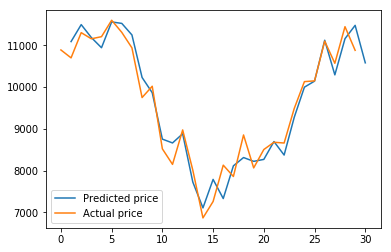

In [15]:
%matplotlib inline
plt.plot(range(1, len(predicted_price)+1), predicted_price, label='Predicted price')
plt.plot(range(len(predicted_price)), actuals, label='Actual price')
plt.legend()
_ = plt.ylim()

# Simulate returns for validation period
position = 0
cash = 1000
for ii in range(len(predicted_price)):
    action = ""
    if prediction[ii] > 0:
        position += cash / actuals[ii] * 0.997 # 0.997 to account for fees
        cash = 0
        action = "BUY"
    
    if prediction[ii] < 0:
        cash += position * actuals[ii] * 0.997
        position = 0
        action = "SELL"
        
    print("Day {}: {}. Price expected to change from {} to {}. Portfolio value of {}".format(ii, action, actuals[ii], predicted_price[ii], position*actuals[ii] + cash))

Some results from playing with hyperparameters
Model 1:
LSTM layers = 2
Hidden nodes = 128
learning rate = 0.00001
batch size = 64
sequence_length = 3
epochs = 2000
val_loss = 0.75104
Portfolio value = $1908

Model 2:
LSTM layers = 2
Hidden nodes = 256
learning rate = 0.00001
batch size = 64
sequence_length = 4
epochs = 2000
val_loss = 0.71283
Portfolio value = 1908

Model 3:
Dropout 20%
LSTM layers = 2
Hidden nodes = 256
learning rate = 0.00001
batch size = 64
sequence_length = 4
epochs = 2000
val_loss = 0.82500
Portfolio value = 1908

Model 4 - Market data only:
LSTM layers = 2
Hidden nodes = 256
learning rate = 0.00001
batch size = 64
sequence_length = 4
epochs = 1250
val_loss = 0.77
Portfolio value = 2068

Model 5 - BTC Kraken market data only:
LSTM layers = 2
Hidden nodes = 256
learning rate = 0.00001
batch size = 64
sequence_length = 4
epochs = 1500
val_loss = 0.67853
Portfolio value = 2017

Model 6 - All BTC market data only:
LSTM layers = 2
Hidden nodes = 256
learning rate = 0.00001
batch size = 64
sequence_length = 4
epochs = 1500
val_loss = 0.83381
Portfolio value = 1961

Model 6 - All BTC and ETH market data only:
LSTM layers = 2
Hidden nodes = 256
learning rate = 0.00001
batch size = 64
sequence_length = 4
epochs = 1500
val_loss = 0.68054
Portfolio value = 2011




## Downloading and evaluating against new test data

In [12]:
start_time_n = datetime(2018,2,21)
end_time_n = datetime(2018,3,17)
interval = 1440
load_test = True

if load_test:
    with open('pickles/test_data.pickle', 'rb') as f:
                test_data = pickle.load(f)
else:
    test_data = processor.historical_download(start_time_n, end_time_n, interval)
    with open('pickles/test_data.pickle', 'wb') as f:
                pickle.dump(test_data, f)


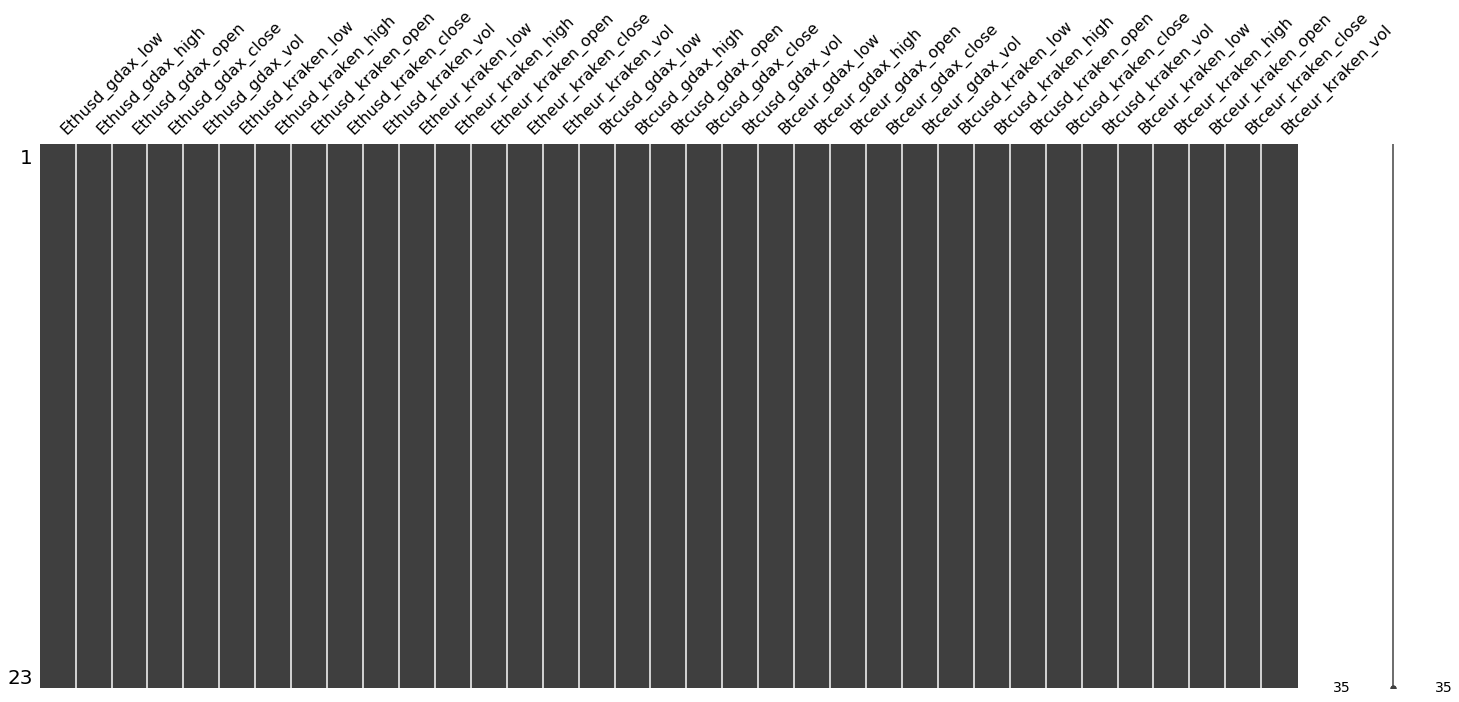

In [13]:
test_data = scrub(test_data)
test_data.drop('Etheur_gdax_low', axis=1, inplace=True)
test_data.drop('Etheur_gdax_high', axis=1, inplace=True)
test_data.drop('Etheur_gdax_open', axis=1, inplace=True)
test_data.drop('Etheur_gdax_close', axis=1, inplace=True)
test_data.drop('Etheur_gdax_vol', axis=1, inplace=True)
#%matplotlib inline
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(data.head(1))
#msno.matrix(test_data)

In [15]:
test_x, test_y, test_actuals = processor.generate_x_y(test_data, target=target, forecast_range=1)

test_x = (test_x - x_mean) / x_std
test_y = (test_y - y_mean) / y_std

test_x_seq, test_y_seq = seq_data(test_x, test_y, sequence_length)
test_actuals_for_seq = test_actuals[sequence_length-1:]

In [16]:
# Load the model weights with the best validation loss.
LSTM_network.model.load_weights('saved_models/LSTM_weights.hdf5')

prediction = []
for ii in range(len(test_x_seq)):
    input_data = np.reshape(test_x_seq[ii], (-1, test_x_seq.shape[1], test_x_seq.shape[2]))
    model_output = LSTM_network.model.predict(input_data)
    prediction.append(model_output.item() * y_std + y_mean)
predicted_price = ([x + 1 for x in prediction]) * test_actuals_for_seq

Day 0: BUY. Price expected to change from 9610.6 to 10225.412957730716. Portfolio value of 1129.620731275883
Day 1: BUY. Price expected to change from 10287.4 to 10646.260353774569. Portfolio value of 1109.9828210517555
Day 2: SELL. Price expected to change from 10914.0 to 10580.018480399887. Portfolio value of 1128.8175791313756
Day 3: BUY. Price expected to change from 10420.9 to 10927.263153353115. Portfolio value of 1204.8308868873032
Day 4: SELL. Price expected to change from 11114.9 to 10937.735615950454. Portfolio value of 1196.780245801821
Day 5: BUY. Price expected to change from 11326.6 to 11378.652402358062. Portfolio value of 1221.990968052833
Day 6: BUY. Price expected to change from 11150.8 to 11506.42655087152. Portfolio value of 1191.4095906368213
Day 7: SELL. Price expected to change from 11539.7 to 11535.15340305478. Portfolio value of 1211.9918057342381
Day 8: SELL. Price expected to change from 11333.3 to 10643.063981050189. Portfolio value of 1211.9918057342381
Day

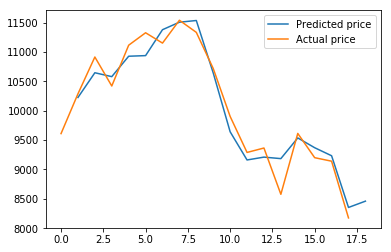

In [18]:
%matplotlib inline
plt.plot(range(1, len(predicted_price)+1), predicted_price, label='Predicted price')
plt.plot(range(len(predicted_price)), test_actuals_for_seq, label='Actual price')
plt.legend()
_ = plt.ylim()

# Simulate returns for validation period
position = 0
cash = 1000
for ii in range(len(predicted_price)):
    action = ""
    if prediction[ii] > 0:
        position += cash / test_actuals_for_seq[ii] * 0.997 # 0.997 to account for fees
        cash = 0
        action = "BUY"
    
    if prediction[ii] < 0:
        cash += position * test_actuals_for_seq[ii] * 0.997
        position = 0
        action = "SELL"
        
    print("Day {}: {}. Price expected to change from {} to {}. Portfolio value of {}".format(ii, action, test_actuals_for_seq[ii], predicted_price[ii], position*actuals[ii] + cash))